## **Resultant Data Schema**:

| Output File | Description |
|:-------------|:-------------|
|**processed_data.json** | Contains the full original dataset |
|**processed_data_balanced.json** | Dataset with records re-balanced across all class labels |
|**processed_data_w_punct.json** | Contains the full original dataset of records (includes punctuation) |
|**processed_data_balanced_w_punct.json** | Dataset with records re-balanced across all class labels (with punctutation) |
|**processed_dialogues.json** | Contains the full original dataset, re-grouped into a dialogue per record |


In each file...
* A list of JSON objects, 1 object per data row in the csv files.

``` python
## JSON Object Structure
# For Utterance-Level
{
    "s/n": <serial number>,         # Sr. No
    "diaID": <dialogue ID>,         # Dialogue_ID
    "uttID": <utterance ID>,        # Utterance_ID
    "split": <train/dev/test>,      # Which dataset split this record came from     
    "y": <emotion label>,           # Emotion
    "sentiment": <sentiment>,       # Sentiment
    "raw": <raw unprocessed text>,  # Utterance
    "clean": "...",                 # Cleaned full utterance text as a string
    "text": [...],                  # List of strings. Cleaned and lemmatised word tokens
    "word_count": <integer>,        # Number of words in "text" variable
    "duration": <numeric>           # Duration of utterance in seconds
},

# For Dialogue-Level
{
    "diaID": <dialogue ID>,         # Dialogue_ID
    "split": <train/dev/test>,      # Which dataset split this record came from     
    "y": [...],                     # Emotion labels as an ordered list
    "sentiment": [...],             # Sentiment labels as an ordered list
    "raw": [...],                   # Utterances as a list of strings
    "words": [...],                 # List of all words in the dialogue, in order. Cleaned and lemmatised word tokens
},
```



In [ ]:
# Import Libraries
import pickle, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import string
import json

## Download Dataset (Raw Data)

In [ ]:
# Download Data from Project GitHub
!wget 'https://raw.githubusercontent.com/r0b0pp1/CS5228_emotion_in_conversation/main/data/raw/dev_sent_emo.csv'
!wget 'https://raw.githubusercontent.com/r0b0pp1/CS5228_emotion_in_conversation/main/data/raw/train_sent_emo.csv'
!wget 'https://raw.githubusercontent.com/r0b0pp1/CS5228_emotion_in_conversation/main/data/raw/test_sent_emo.csv'

In [ ]:
# Download CSV files to Colab Environment
DEV_CSV_FILE_PATH = 'dev_sent_emo.csv'
TRAIN_CSV_FILE_PATH = 'train_sent_emo.csv'
TEST_CSV_FILE_PATH = 'test_sent_emo.csv'

# Collect all data records into 1 dataframe and print simple statistics
df_raw_1 = pd.read_csv(DEV_CSV_FILE_PATH)
df_raw_2 = pd.read_csv(TRAIN_CSV_FILE_PATH)
df_raw_3 = pd.read_csv(TEST_CSV_FILE_PATH)

# Indicate split record belongs to
df_raw_1['split'] = 'dev'
df_raw_2['split'] = 'train'
df_raw_3['split'] = 'test'

df_raw = pd.concat([df_raw_1, df_raw_2, df_raw_3])
df_raw.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,split
0,1,"Oh my God, he’s lost it. He’s totally lost it.",Phoebe,sadness,negative,0,0,4,7,"00:20:57,256","00:21:00,049",dev
1,2,What?,Monica,surprise,negative,0,1,4,7,"00:21:01,927","00:21:03,261",dev
2,3,"Or! Or, we could go to the bank, close our acc...",Ross,neutral,neutral,1,0,4,4,"00:12:24,660","00:12:30,915",dev
3,4,You’re a genius!,Chandler,joy,positive,1,1,4,4,"00:12:32,334","00:12:33,960",dev
4,5,"Aww, man, now we won’t be bank buddies!",Joey,sadness,negative,1,2,4,4,"00:12:34,211","00:12:37,505",dev


## Dataset Statistics

============= GENERAL STATISTICS ==============
# of Records: 13708
# of Columns: 12
Columns: Sr No. | Utterance | Speaker | Emotion | Sentiment | Dialogue_ID | Utterance_ID | Season | Episode | StartTime | EndTime | split
Train-Dev-Test Split:
split
train    9989
test     2610
dev      1109
Name: count, dtype: int64


<Axes: ylabel='Dataset Split'>

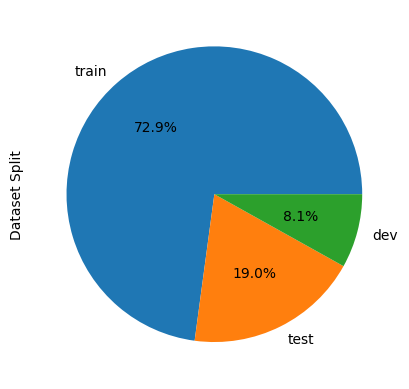

In [ ]:
#@title <font size="4">General Statistics { vertical-output: true }
print("============= GENERAL STATISTICS ==============")
print(f"# of Records: {df_raw.shape[0]}")
print(f"# of Columns: {len(df_raw.columns)}")
print(f"Columns: {' | '.join(list(df_raw.columns))}")

dataset_split_info = df_raw['split'].value_counts()
print("Train-Dev-Test Split:")
print(dataset_split_info)
# Plot distribution in a pie chart
dataset_split_info.plot(kind='pie', ylabel="Dataset Split", autopct='%1.1f%%')



============= EMOTION LABELS ==============
# of Labels: 7

Label Distribution:
Emotion
neutral     6436
joy         2308
surprise    1636
anger       1607
sadness     1002
disgust      361
fear         358
Name: count, dtype: int64


<Axes: ylabel='Emotion Labels'>

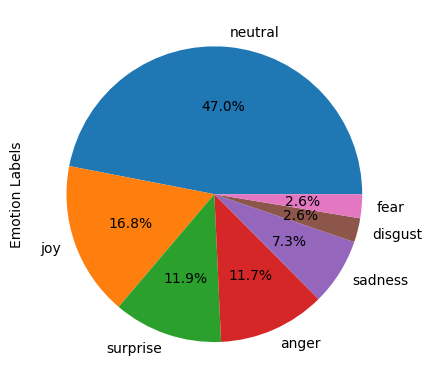

In [ ]:
#@title <font size="4">Label Distribution { vertical-output: true }
unique_emo_labels = df_raw['Emotion'].value_counts()
print("\n============= EMOTION LABELS ==============")
print(f"# of Labels: {len(unique_emo_labels)}")
print(f"\nLabel Distribution:")
print(unique_emo_labels)

# Plot distribution in a pie chart
unique_emo_labels.plot(kind='pie', ylabel="Emotion Labels", autopct='%1.1f%%')


In [ ]:
#@title <font size="4">Speaker Statistics { vertical-output: true }
unique_speakers = df_raw['Speaker'].unique()
unique_speakers.sort()
speaker_dist = df_raw['Speaker'].value_counts()
print("\n============= SPEAKERS ==============")
print(f"# of Speakers: {len(unique_speakers)}")
print(f"\nSpeaker Distribution:")
print(speaker_dist)



============= SPEAKERS ==============
# of Speakers: 304

Speaker Distribution:
Speaker
Joey               2070
Ross               2048
Rachel             1955
Phoebe             1797
Monica             1782
                   ... 
Raymond               1
Drunken Gambler       1
Passerby              1
Cookie                1
Nurse #1              1
Name: count, Length: 304, dtype: int64


## **Data Cleaning**
*   Make all text lowercase
*   Standardisation of quotation marks as different symbols used
*   Tokenisation
*   Lemmatisation of words
*   Replace all mentions of speaker names as \<PER\> - to disassociate speakers from the context


In [ ]:
#@title <font size="4">Making a List of Named Speakers (SPEAKER_NAMES) { vertical-output: true }
# Get the list of unique named speakers
SPEAKER_NAMES = []

## Regular expressions
# Delimiters indicating (1) multiple participants OR (2) names with surnames
DELIMITERS = [" and ", "/", " "]
delimiters_regex = "|".join(DELIMITERS).replace(" ", "\s")
#print(f"EXCLUDED REGEX: {delimiters_regex}")  ## DEBUG

# Titles prefixing a named character
# (to remove title, not exclude name)
SALUTATIONS = ["dr", "mrs", "mr", "ms", "aunt", "doctor", "guru"]
salutations_regex = "\s|".join(SALUTATIONS)
#print(f"EXCLUDED REGEX: {salutations_regex}")  ## DEBUG

# Identifiers of unnamed characters - (exclude names with these)
EXCLUDED_TERMS = ["#", "^a\s", "\’s", "\'s", "^all$", "\ssr", "the\s"]
EXCLUDED_TERMS.extend(
    ["actress", "another", "announcer", "attendant",
     "bastard", "bitch", "both", "clerk", "commercial",
     "customer", "doctor", "drunken", "director", "employee",
     "female", "fireman", "friend", "green", "girl", "guide",
     "^guy$", "hitchhiker", "host", "hypnosis", "janitor", "judge",
     "leader", "lecturer", "\sman", "^man$", "message", "nurse", "older",
     "paleontologist", "passerby","policeman", "receptionist",
     "singer", "stage", "student", "stranger", "supervisor",
     "teacher", "^tag$", "voice", "volunteer",
     "waiter", "waitress", "woman"])
excluded_regex = "|".join(EXCLUDED_TERMS)
print(f"EXCLUDED REGEX: {excluded_regex}\n")  ## DEBUG

# Adjectives describing named characters - (to exclude these, but not the names)
ADJECTIVES = ["fake", "long", "young"]

###
# Splits a string containing multiple speaker names into a list
# of individual names
# @returns: {List} speaker names
###
def split_multiple_speakers(speaker_names) -> list:
  for delimiter in DELIMITERS:
    if re.search(delimiter, speaker_names):
      return speaker_name.split(delimiter)
  return [speaker_names]

###
# Removes salutations from a name
# @returns: {List} speaker names
###
def remove_salutations(speaker_name) -> str:
  for salutation in SALUTATIONS:
    if speaker_name.startswith(salutation):
      return speaker_name.replace(salutation, "", 1).replace(".", "").strip()

###
# Removes overlapping elements in both lists.
# (Warning: Performing set operation. List must not contain duplicates or they will be removed)
# @returns: {List} target_list with intersecting elements removed
###
def remove_list_intersection(target_list, subset_list) -> list:
  target_set = set(target_list)
  subset = set(subset_list)
  # print(f"Removing intersection: {target_set} <---> {subset}")  ## DEBUG
  target_set.difference_update(subset)
  # print(f"===> {list(target_set)}\n")  ## DEBUG
  return list(target_set)

############## MAIN LOOP: Retain only named characters ##############
added_counter = 0
drop_counter = 0

# Keep First and Last Name as separate names just in case
# both are referenced
for speaker_name in unique_speakers:
  original_string = speaker_name+""   ## DEBUG
  speaker_name = speaker_name.lower().replace(".", "")
  if re.search(excluded_regex, speaker_name):
    # Ignore generic names
    print(f"Dropped: {original_string} --> {speaker_name}")  ## DEBUG
    drop_counter += 1  ## DEBUG: Ensure numbers add up
    continue
  elif re.match(salutations_regex, speaker_name):
    # Remove salutations from names
    speaker_name = remove_salutations(speaker_name)
    # print(f"Remove saluations from {original_string} --> {speaker_name}") ## DEBUG

  if re.search(delimiters_regex, speaker_name):
    # Split conjunctions of 2 names
    speaker_names = split_multiple_speakers(speaker_name)
    # print(f"Multiple Added: {speaker_name} --> {speaker_names}")  ## DEBUG
    remove_list_intersection(speaker_names, ADJECTIVES)
    SPEAKER_NAMES.extend(speaker_names)
    added_counter += 1 ## DEBUG: Ensure numbers add up
  else:
    # print(f"Added: {original_string} --> {speaker_name}") ## DEBUG
    SPEAKER_NAMES.append(speaker_name)
    added_counter += 1   ## DEBUG: Ensure numbers add up

## POST-PROCESSING
# Remove duplicate names
SPEAKER_NAMES = set(SPEAKER_NAMES)

# Remove specific
special_excludes = ["", "d'", "an", "cookie", "hope"] + ADJECTIVES
SPEAKER_NAMES = remove_list_intersection(SPEAKER_NAMES, special_excludes)
# Sort alphabetically
SPEAKER_NAMES.sort()

# Final Results
print("=========== NAMED SPEAKERS ============")
print(f"Retained: {added_counter} | Dropped: {drop_counter} | Total: {added_counter + drop_counter}")
print(f"# of Named Speakers: {len(SPEAKER_NAMES)}")

curr_first_char = SPEAKER_NAMES[0][0]
print(f"\nNames starting with {curr_first_char.upper()}...")
for speaker in SPEAKER_NAMES:
  firstChar = speaker[0]
  if not firstChar == curr_first_char:
    curr_first_char = firstChar
    print(f"\n\nNames starting with {curr_first_char.upper()}...")
  print(speaker, end=" | ")

EXCLUDED REGEX: #|^a\s|\’s|'s|^all$|\ssr|the\s|actress|another|announcer|attendant|bastard|bitch|both|clerk|commercial|customer|doctor|drunken|director|employee|female|fireman|friend|green|girl|guide|^guy$|hitchhiker|host|hypnosis|janitor|judge|leader|lecturer|\sman|^man$|message|nurse|older|paleontologist|passerby|policeman|receptionist|singer|stage|student|stranger|supervisor|teacher|^tag$|voice|volunteer|waiter|waitress|woman

Dropped: 1st Customer --> 1st customer
Dropped: 2nd Customer --> 2nd customer
Dropped: 3rd Customer --> 3rd customer
Dropped: A Female Student --> a female student
Dropped: A Student --> a student
Dropped: A Waiter --> a waiter
Dropped: Airline Employee --> airline employee
Dropped: All --> all
Dropped: Another Scientist --> another scientist
Dropped: Another Tour Guide --> another tour guide
Dropped: Both --> both
Dropped: Boy in the Cape --> boy in the cape
Dropped: Commercial --> commercial
Dropped: Customer --> customer
Dropped: Director --> director
Dropp

In [ ]:
#@title <font size="4">Cleaning Data: Utterances{ vertical-output: true }
NAME_TOKEN = '<PER>'
'''
We retain aprostrophe in the text as our dataset is informal speech
and there are a lot of abbreviations like (y'know) where the
aprostrophe hints at a tokenisation into 2 separate words
(E.g. y'know --> you know)
'''
UNWANTED_PUNCTUATION = string.punctuation.replace("'", "")

###
# Removes all punctuation from a string
# @returns:{String} string with no punctuation
###
def remove_punctuation(text) -> str:
  cleaned = text.translate(str.maketrans('', '', UNWANTED_PUNCTUATION))
  cleaned = standardise_quotes(cleaned)    # standardise aprostrophes for lemmatisation
  return cleaned

###
# Standardises the symbols used for aprostrophes
# @returns:{String} string with all aprostrophes set to (')
###
def standardise_quotes(text) -> str:
  return re.sub(r'[‘’]',"'", text)    # standardise aprostrophes for lemmatisation

###
# Makes all words in a string lowercase
# @returns:{String} string in all lowercase
###
def make_lower_case(text) -> str:
  return text.lower()

###
# Makes all speaker names occurring in list SPEAKER_NAMES anonymous by replacing them with the <PER> tag
# @returns:{String} string with names hidden
###
def anonymise_speaker_names(text) -> str:
  cleaned_str = text
  for person_name in SPEAKER_NAMES:
    if re.search(person_name+"\s", cleaned_str):
      cleaned_str = re.sub(person_name, '<PER>', cleaned_str)
      print(f"Cleaned [{person_name}] to <PER>")
      print(f"| {text} --> {cleaned_str}\n")
  return cleaned_str

################ UTTERANCES: Pre-Processing Steps #####################
df_cleaned = df_raw.copy()

# Manually add missing dialogue

# 1. Reformat all text to lowercase
df_cleaned['Utterance'] = df_cleaned['Utterance'].apply(make_lower_case)
# 2. Remove punctuation
df_cleaned['cleaned'] = df_cleaned['Utterance'].apply(remove_punctuation)
df_cleaned['cleaned_w_punct'] = df_cleaned['Utterance'].apply(standardise_quotes)
# 3. Replace all speaker names with <PER> for speaker independence
df_cleaned['cleaned'] = df_cleaned['cleaned'].apply(anonymise_speaker_names)
df_cleaned['cleaned_w_punct'] = df_cleaned['cleaned_w_punct'].apply(anonymise_speaker_names)


Streaming output truncated to the last 5000 lines.
| kathy kathy hi kathy kathy she doesn't hear him and keeps running chandler starts chasing her as the theme to --> <PER> <PER> hi <PER> <PER> she doesn't hear him and keeps running <PER> starts chasing her as the theme to

Cleaned [chandler] to <PER>
| hey chandler what are you doing here --> hey <PER> what are you doing here

Cleaned [ross] to <PER>
| our eyes are closed and we're about to cross the street very good --> our eyes are closed and we're about to c<PER> the street very good

Cleaned [ross] to <PER>
| all right ross do you think it's easy for me to see you with somebody else --> all right <PER> do you think it's easy for me to see you with somebody else

Cleaned [ross] to <PER>
| ross i still can't forgive you for what you did i can't i just but sometimes when i'm with you i just i feel so --> <PER> i still can't forgive you for what you did i can't i just but sometimes when i'm with you i just i feel so

Cleaned [chandler

In [ ]:
#@title <font size="4">Cleaning Data: Speaker Names{ vertical-output: true }

################ SPEAKERS: Pre-Processing Steps #####################
# Make copy of dataframe for cleaning
df = df_cleaned.copy()
# 1. Reformat all text to lowercase
df['Speaker'] = df['Speaker'].apply(make_lower_case)

# 2. Correct Mispelled Speaker Names
# Correct: ledbetter | Wrong: leedbetter
affected_row = df.loc[df['Speaker'].str.contains("leedbetter"), 'Speaker']
print(affected_row)
df.loc[df['Speaker'].str.contains("leedbetter"), 'Speaker'] = 'ledbetter'
print(df.loc[df['Speaker'].str.contains("leedbetter"), 'Speaker'])

# Some non-human participants/uninformative
# hypnosis tape
# hold voice
# voice

df_cleaned = df.copy()

2475    dr. leedbetter
Name: Speaker, dtype: object
Series([], Name: Speaker, dtype: object)


In [ ]:
df_cleaned.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,split,cleaned,cleaned_w_punct
0,1,"oh my god, he’s lost it. he’s totally lost it.",phoebe,sadness,negative,0,0,4,7,"00:20:57,256","00:21:00,049",dev,oh my god he's lost it he's totally lost it,"oh my god, he's lost it. he's totally lost it."
1,2,what?,monica,surprise,negative,0,1,4,7,"00:21:01,927","00:21:03,261",dev,what,what?
2,3,"or! or, we could go to the bank, close our acc...",ross,neutral,neutral,1,0,4,4,"00:12:24,660","00:12:30,915",dev,or or we could go to the bank close our accoun...,"or! or, we could go to the bank, close our acc..."
3,4,you’re a genius!,chandler,joy,positive,1,1,4,4,"00:12:32,334","00:12:33,960",dev,you're a genius,you're a genius!
4,5,"aww, man, now we won’t be bank buddies!",joey,sadness,negative,1,2,4,4,"00:12:34,211","00:12:37,505",dev,aww man now we won't be bank buddies,"aww, man, now we won't be bank buddies!"


## New Feature Generation

New Columns:
* **tokenised**: List of word tokens in utterance
* **lemmatised**: Tokenised utterance reduced into their base forms
* **duration**: Time duration of the utterance

(Decided not to remove stop words as due to the nature of informal, conversational speech, a lot of words count as stop words, leaving empty tokenised dialogue)


In [ ]:
# Customise Spacy Tokeniser
import spacy
from spacy.tokenizer import Tokenizer
from spacy.attrs import ORTH, NORM
from spacy.util import compile_infix_regex
nlp = spacy.load("en_core_web_sm")

### Customise default tokeniser
tokeniser = nlp.tokenizer

# Declare that <> are allowed
nlp.tokenizer.infix_finditer = compile_infix_regex([r"([\<\>])"]).finditer

# Special Case: Treat <PER> token as 1 word
tokeniser.add_special_case("<PER>", [{ORTH: "<PER>"}])
# Special Case: You- conjunctions not being split
tokeniser.add_special_case("y'know", [{ORTH: "y'", NORM: "you"}, {ORTH: "know"}])
tokeniser.add_special_case("you're", [{ORTH: "you"}, {ORTH: "'re", NORM: "are"}])
nlp.tokenizer = tokeniser

print(nlp.tokenizer.explain("y'know"))
print(nlp.tokenizer.explain("you're"))

[('SPECIAL-1', "y'"), ('SPECIAL-2', 'know')]
[('SPECIAL-1', 'you'), ('SPECIAL-2', "'re")]


In [ ]:
#@title <font size="4">Word Processing (Tokenisation & Lemmatisation){ vertical-output: true }

###
# Special post-processing to be done on words that could not be handled by tokenizer
# @returns: corrected word token
###
def word_special_handling(token) -> str:
  token_text = token.text.strip()
  if len(token_text) <= 1 and any(char in string.punctuation for char in token_text):
    # print(f"Found punctuation in token: {token}")
    return "" # exclude punctuation-only words
  return token_text

###
# Retains <PER> tags in upper case. Lemmatizer sometimes makes them lowercase
# @returns: corrected lemma
###
def lemma_special_handling(lemma) -> str:
  if lemma == "<per>":
    return "<PER>"
  elif lemma == "y'":
    return "you"
  elif lemma == "'s":
    return "is"
  else:
    return lemma

###
# Breaks a sentence into words and converts them into their root forms
# Includes (1) Tokenisation and (2) Lemmatisation
# @returns:{List} list of word tokens in utterance
###
def get_base_words(utterance, include_punctuation=False) -> list:
  doc = nlp(utterance)
  word_tokens = []
  word_lemmas = []
  for token in doc:
    # Remove stopwords, unless the utterance is only 1 word long
    #if token.is_stop and len(doc) > 1:
    #  continue
    token_text = word_special_handling(token)
    lemma = lemma_special_handling(token.lemma_)
    if len(token_text.strip()) > 0:
      word_tokens.append(token_text)  # Accumulate word tokens
      word_lemmas.append(lemma)       # Accumulate lemmas
    elif len(doc) == 1 or include_punctuation:
      # Do not remove stopwords from single word
      word_tokens.append(token.text)
      word_lemmas.append(lemma)
  return pd.Series([word_tokens, word_lemmas, len(word_tokens), len(word_lemmas)])

# Make a copy of the dataframe
df_tokenised = df_cleaned.copy()
# # Tokenise the cleaned utterances
word_columns = df_tokenised['cleaned'].apply(lambda x: get_base_words(x))
word_columns.columns = ['tokenised', 'lemmatised', 'word_count', 'word_count_lemmas']
df_tokenised = pd.concat([df_tokenised, word_columns], axis=1)

word_columns_w_punct = df_tokenised['cleaned_w_punct'].apply(lambda x: get_base_words(x, include_punctuation=True))
word_columns_w_punct.columns = ['punct_tokenised', 'punct_lemmatised', 'punct_word_count', 'punct_word_count_lemmas']
df_tokenised = pd.concat([df_tokenised, word_columns_w_punct], axis=1)
print()


In [ ]:
df_tokenised.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,...,cleaned,cleaned_w_punct,tokenised,lemmatised,word_count,word_count_lemmas,punct_tokenised,punct_lemmatised,punct_word_count,punct_word_count_lemmas
0,1,"oh my god, he’s lost it. he’s totally lost it.",phoebe,sadness,negative,0,0,4,7,"00:20:57,256",...,oh my god he's lost it he's totally lost it,"oh my god, he's lost it. he's totally lost it.","[oh, my, god, he, 's, lost, it, he, 's, totall...","[oh, my, god, he, be, lose, it, he, be, totall...",12,12,"[oh, my, god, ,, he, 's, lost, it, ., he, 's, ...","[oh, my, god, ,, he, be, lose, it, ., he, be, ...",15,15
1,2,what?,monica,surprise,negative,0,1,4,7,"00:21:01,927",...,what,what?,[what],[what],1,1,"[what, ?]","[what, ?]",2,2
2,3,"or! or, we could go to the bank, close our acc...",ross,neutral,neutral,1,0,4,4,"00:12:24,660",...,or or we could go to the bank close our accoun...,"or! or, we could go to the bank, close our acc...","[or, or, we, could, go, to, the, bank, close, ...","[or, or, we, could, go, to, the, bank, close, ...",18,18,"[or, !, or, ,, we, could, go, to, the, bank, ,...","[or, !, or, ,, we, could, go, to, the, bank, ,...",22,22
3,4,you’re a genius!,chandler,joy,positive,1,1,4,4,"00:12:32,334",...,you're a genius,you're a genius!,"[you, 're, a, genius]","[you, be, a, genius]",4,4,"[you, 're, a, genius, !]","[you, be, a, genius, !]",5,5
4,5,"aww, man, now we won’t be bank buddies!",joey,sadness,negative,1,2,4,4,"00:12:34,211",...,aww man now we won't be bank buddies,"aww, man, now we won't be bank buddies!","[aww, man, now, we, wo, n't, be, bank, buddies]","[aww, man, now, we, will, not, be, bank, buddy]",9,9,"[aww, ,, man, ,, now, we, wo, n't, be, bank, b...","[aww, ,, man, ,, now, we, will, not, be, bank,...",12,12


In [ ]:
#@title <font size="4">Utterance Duration (in seconds){ vertical-output: false }
# Dialogue Duration
df_features = df_tokenised.copy()

# Convert string columns to datetime
df_start_time = pd.to_datetime(df_features['StartTime'])
df_end_time = pd.to_datetime(df_features['EndTime'])

# Calculate the time differences
df_features['duration'] = (df_end_time - df_start_time).dt.total_seconds()

df_features.head()

<ipython-input-15-a05b99937265>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_start_time = pd.to_datetime(df_features['StartTime'])
<ipython-input-15-a05b99937265>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_end_time = pd.to_datetime(df_features['EndTime'])


,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,...,cleaned_w_punct,tokenised,lemmatised,word_count,word_count_lemmas,punct_tokenised,punct_lemmatised,punct_word_count,punct_word_count_lemmas,duration
0,1,"oh my god, he’s lost it. he’s totally lost it.",phoebe,sadness,negative,0,0,4,7,"00:20:57,256",...,"oh my god, he's lost it. he's totally lost it.","[oh, my, god, he, 's, lost, it, he, 's, totall...","[oh, my, god, he, be, lose, it, he, be, totall...",12,12,"[oh, my, god, ,, he, 's, lost, it, ., he, 's, ...","[oh, my, god, ,, he, be, lose, it, ., he, be, ...",15,15,3.0
1,2,what?,monica,surprise,negative,0,1,4,7,"00:21:01,927",...,what?,[what],[what],1,1,"[what, ?]","[what, ?]",2,2,2.0
2,3,"or! or, we could go to the bank, close our acc...",ross,neutral,neutral,1,0,4,4,"00:12:24,660",...,"or! or, we could go to the bank, close our acc...","[or, or, we, could, go, to, the, bank, close, ...","[or, or, we, could, go, to, the, bank, close, ...",18,18,"[or, !, or, ,, we, could, go, to, the, bank, ,...","[or, !, or, ,, we, could, go, to, the, bank, ,...",22,22,6.0
3,4,you’re a genius!,chandler,joy,positive,1,1,4,4,"00:12:32,334",...,you're a genius!,"[you, 're, a, genius]","[you, be, a, genius]",4,4,"[you, 're, a, genius, !]","[you, be, a, genius, !]",5,5,1.0
4,5,"aww, man, now we won’t be bank buddies!",joey,sadness,negative,1,2,4,4,"00:12:34,211",...,"aww, man, now we won't be bank buddies!","[aww, man, now, we, wo, n't, be, bank, buddies]","[aww, man, now, we, will, not, be, bank, buddy]",9,9,"[aww, ,, man, ,, now, we, wo, n't, be, bank, b...","[aww, ,, man, ,, now, we, will, not, be, bank,...",12,12,3.0


In [ ]:
df_final_full = df_features.copy()

## Checkpoint: Output to CSV for easier checking
!mkdir -p 'checkpoints/'
df_final_full.to_csv('checkpoints/complete_raw_data.csv')

## **Handling of Labels Imbalance**

====STATISTICS FOR TRAINING DATASET ====
# of Records: 9989


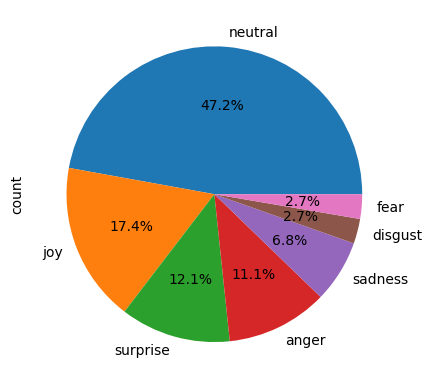

In [ ]:
#@title <font size="4">Training Dataset: Label Imbalance{ vertical-output: true }

# Evaluate Imbalance in Training Dataset
df_train = df_final_full.copy()
df_train = df_train[df_train['split'] == 'train']
print("====STATISTICS FOR TRAINING DATASET ====")
print(f"# of Records: {df_train.shape[0]}")
df_train['Emotion'].value_counts().plot(kind='pie', y='Emotion Labels', autopct='%1.1f%%')

RESAMPLED_LABELS = []     # Labels to be resampled
RESAMPLED_CLASSES = []    # Dataframes with resampled rows

##
# Prints out the pie chart of the revised class labels distribution
# and returns the overall resampled dataframe
# - returns {Dataframe} resultant dataframe with resampling applied
##
def evaluate_resultant_resampled_dataset():
  df_other_labels = df_train[~df_train['Emotion'].isin(RESAMPLED_LABELS)]
  print(f">>> Added to {df_other_labels.shape[0]} other rows.\n")

  df_train_resampled = pd.concat([df_other_labels] + RESAMPLED_CLASSES)
  df_train_resampled.sort_values(by='Dialogue_ID')
  df_train_resampled['Emotion'].value_counts().plot(kind='pie', y='Emotion Labels', autopct='%1.1f%%')
  return df_train_resampled




Training Dataset Size: 9989
# of neutral: 4710
Target # of neutral: 1498
# to remove: 3212
====Word Counts per message====
Median: 7.0
3513     0
9987     1
3143     1
3144     1
2963     1
        ..
9745    39
5438    39
5861    40
7143    48
4779    50
Name: word_count, Length: 4710, dtype: int64

Removing zero-length utterances...
>>> Removed: 1 | Left: 4709

Perform Random Sampling...
>>> Got 1498 neutral rows.
>>> Added to 5279 other rows.




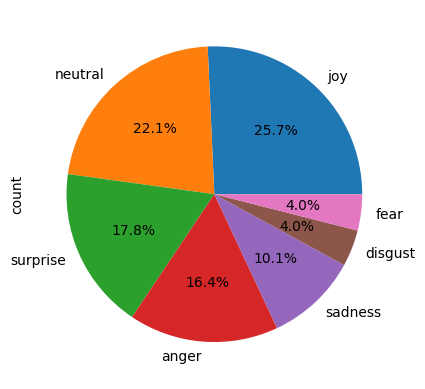

In [ ]:
#@title <font size="4">Downsampling of Majority Class (Emotion: neutral){ vertical-output: true }
RESAMPLED_LABELS.append('neutral')

## For Training Split
df_train_neutral = df_train[df_train['Emotion'] == 'neutral']

TRAIN_DATASET_SIZE = df_train.shape[0]
TRAIN_NEUTRAL_ROW_COUNT = df_train_neutral.shape[0]
retain_percentage = 0.15
TARGET_NUM_ROWS = int(df_train.shape[0] * retain_percentage)

neutral_to_remove = TRAIN_NEUTRAL_ROW_COUNT - TARGET_NUM_ROWS
print(f"Training Dataset Size: {TRAIN_DATASET_SIZE}")
print(f"# of neutral: {TRAIN_NEUTRAL_ROW_COUNT}")
print(f"Target # of neutral: {TARGET_NUM_ROWS}")
print(f"# to remove: {neutral_to_remove}")

# Undersample by removing empty/shorter utterances
print("====Word Counts per message====")
median_utterance_length = df_train_neutral['word_count'].median()
print(f"Median: {median_utterance_length}")
print(df_train_neutral['word_count'].sort_values(ascending=True))

# Remove 0 length utterances
df_train_neutral = df_train_neutral[df_train_neutral['word_count'] > 0]
remaining_count = df_train_neutral.shape[0]
print("\nRemoving zero-length utterances...")
print(f">>> Removed: {TRAIN_NEUTRAL_ROW_COUNT - remaining_count} | Left: {remaining_count}")

# Random Sampling of remainder
print("\nPerform Random Sampling...")
RANDOM_SEED = 42
df_sampled_neutral = df_train_neutral.sample(n=TARGET_NUM_ROWS, random_state=RANDOM_SEED)  # Set random_state for reproducibility
print(f">>> Got {df_sampled_neutral.shape[0]} neutral rows.")

RESAMPLED_CLASSES.append(df_sampled_neutral)

evaluate_resultant_resampled_dataset()
print()

Training Dataset Size: 9989
# of fear: 268
# of digust: 271
Target # of fear: 998
>>> Got 998 fear rows.
>>> Got 998 disgust rows.
>>> Added to 4740 other rows.



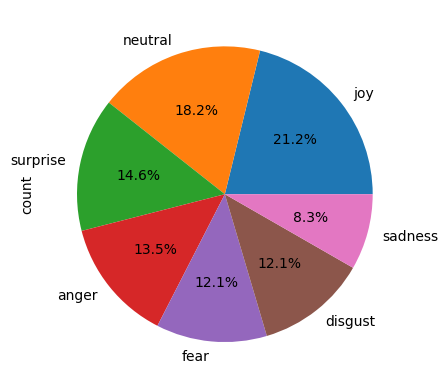

In [ ]:
#@title <font size="4">Oversampling of Minority Classes (Emotion: fear/disgust){ vertical-output: true }
RESAMPLED_LABELS.extend(['fear', 'disgust'])

# Oversample Fear and Disgust
df_train_fear = df_train[df_train['Emotion'] == 'fear']
df_train_disgust = df_train[df_train['Emotion'] == 'disgust']

# Statistics print-out
FEAR_ROW_COUNT = df_train_fear.shape[0]
DISGUST_ROW_COUNT = df_train_disgust.shape[0]
target_percentage = 0.10
TARGET_NUM_ROWS = int(TRAIN_DATASET_SIZE * target_percentage)

print(f"Training Dataset Size: {TRAIN_DATASET_SIZE}")
print(f"# of fear: {FEAR_ROW_COUNT}")
print(f"# of digust: {DISGUST_ROW_COUNT}")
print(f"Target # of fear: {TARGET_NUM_ROWS}")

# Oversample fear
df_sampled_fear = df_train_fear.sample(
    n=TARGET_NUM_ROWS, replace=True, random_state=RANDOM_SEED)  # Set random_state for reproducibility
print(f">>> Got {df_sampled_fear.shape[0]} fear rows.")

# Oversample disgust
df_sampled_disgust = df_train_disgust.sample(
    n=TARGET_NUM_ROWS, replace=True, random_state=RANDOM_SEED)  # Set random_state for reproducibility
print(f">>> Got {df_sampled_fear.shape[0]} disgust rows.")

RESAMPLED_CLASSES.extend([df_sampled_fear, df_sampled_disgust])

df_train_resampled = evaluate_resultant_resampled_dataset()

In [ ]:
#@title <font size="4">After Re-balancing{ vertical-output: false }

print("====STATISTICS AFTER RESAMPLING ====")
print(f"Resulting Train Dataset Size: {df_train_resampled.shape[0]}")
df_train_resampled.head()




====STATISTICS AFTER RESAMPLING ====
Resulting Train Dataset Size: 8234


,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,...,cleaned_w_punct,tokenised,lemmatised,word_count,word_count_lemmas,punct_tokenised,punct_lemmatised,punct_word_count,punct_word_count_lemmas,duration
4,5,my duties? all right.,chandler,surprise,positive,0,4,8,21,"00:16:34,452",...,my duties? all right.,"[my, duties, all, right]","[my, duty, all, right]",4,4,"[my, duties, ?, , all, right, .]","[my, duty, ?, , all, right, .]",7,7,6.0
12,13,really?!,chandler,surprise,positive,0,12,8,21,"00:17:13,491",...,really?!,[really],[really],1,1,"[really, ?, !]","[really, ?, !]",3,3,3.0
14,15,but then who? the waitress i went out with las...,joey,surprise,negative,1,0,9,23,"00:36:40,364",...,but then who? the waitress i went out with las...,"[but, then, who, the, waitress, i, went, out, ...","[but, then, who, the, waitress, I, go, out, wi...",11,11,"[but, then, who, ?, the, waitress, i, went, ou...","[but, then, who, ?, the, waitress, I, go, out,...",13,13,2.0
15,16,you know? forget it!,rachel,sadness,negative,1,1,9,23,"00:36:44,368",...,you know? forget it!,"[you, know, forget, it]","[you, know, forget, it]",4,4,"[you, know, ?, forget, it, !]","[you, know, ?, forget, it, !]",6,6,2.0
16,17,"no-no-no-no, no! who, who were you talking about?",joey,surprise,negative,1,2,9,23,"00:36:44,368",...,"no-no-no-no, no! who, who were you talking about?","[nononono, no, who, who, were, you, talking, a...","[nononono, no, who, who, be, you, talk, about]",8,8,"[no-no-no-no, ,, no, !, who, ,, who, were, you...","[no-no-no-no, ,, no, !, who, ,, who, be, you, ...",12,12,5.0


====STATISTICS FOR WHOLE DATASET ====
# of Records: 11953


<Axes: ylabel='count'>

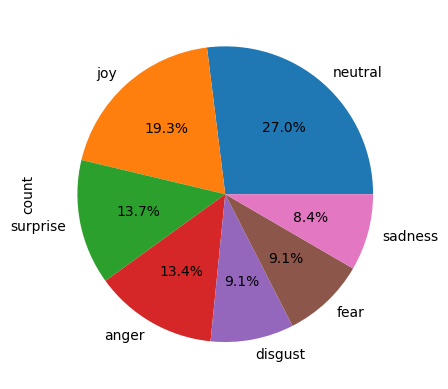

In [ ]:
#@title <font size="4">Overall Dataset Balance{ vertical-output: true }
# Evaluate Imbalance
df_dev_test = df_final_full[df_final_full['split'] != 'train'].copy()
df_final_resampled = pd.concat([df_dev_test, df_train_resampled])
df_final_resampled.sort_values(by=['split', 'Dialogue_ID'])

print("====STATISTICS FOR WHOLE DATASET ====")
print(f"# of Records: {df_final_resampled.shape[0]}")
df_final_resampled['Emotion'].value_counts().plot(kind='pie', y='Emotion Labels', autopct='%1.1f%%')



In [ ]:
df_final_resampled.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,...,cleaned_w_punct,tokenised,lemmatised,word_count,word_count_lemmas,punct_tokenised,punct_lemmatised,punct_word_count,punct_word_count_lemmas,duration
0,1,"oh my god, he’s lost it. he’s totally lost it.",phoebe,sadness,negative,0,0,4,7,"00:20:57,256",...,"oh my god, he's lost it. he's totally lost it.","[oh, my, god, he, 's, lost, it, he, 's, totall...","[oh, my, god, he, be, lose, it, he, be, totall...",12,12,"[oh, my, god, ,, he, 's, lost, it, ., he, 's, ...","[oh, my, god, ,, he, be, lose, it, ., he, be, ...",15,15,3.0
1,2,what?,monica,surprise,negative,0,1,4,7,"00:21:01,927",...,what?,[what],[what],1,1,"[what, ?]","[what, ?]",2,2,2.0
2,3,"or! or, we could go to the bank, close our acc...",ross,neutral,neutral,1,0,4,4,"00:12:24,660",...,"or! or, we could go to the bank, close our acc...","[or, or, we, could, go, to, the, bank, close, ...","[or, or, we, could, go, to, the, bank, close, ...",18,18,"[or, !, or, ,, we, could, go, to, the, bank, ,...","[or, !, or, ,, we, could, go, to, the, bank, ,...",22,22,6.0
3,4,you’re a genius!,chandler,joy,positive,1,1,4,4,"00:12:32,334",...,you're a genius!,"[you, 're, a, genius]","[you, be, a, genius]",4,4,"[you, 're, a, genius, !]","[you, be, a, genius, !]",5,5,1.0
4,5,"aww, man, now we won’t be bank buddies!",joey,sadness,negative,1,2,4,4,"00:12:34,211",...,"aww, man, now we won't be bank buddies!","[aww, man, now, we, wo, n't, be, bank, buddies]","[aww, man, now, we, will, not, be, bank, buddy]",9,9,"[aww, ,, man, ,, now, we, wo, n't, be, bank, b...","[aww, ,, man, ,, now, we, will, not, be, bank,...",12,12,3.0


## Generating Dialogue Level Collections

In [ ]:
#@title <font size="4">Collecting Utterances into Dialogues{ vertical-output: false }
# Collect Utterances as Dialogues
selected_columns = ['cleaned_w_punct', 'Speaker', 'Emotion', 'Sentiment', 'Dialogue_ID']
column_as_list = {key: list for key in selected_columns}
del column_as_list['Dialogue_ID']
df_dev = df_final_full[df_final_full['split'] == 'dev']
df_dialogues_dev = df_dev[selected_columns].copy().groupby('Dialogue_ID', as_index=False).agg(column_as_list)
df_dialogues_dev['split'] = 'dev'

df_train = df_final_full[df_final_full['split'] == 'train']
df_dialogues_train = df_train[selected_columns].copy().groupby('Dialogue_ID', as_index=False).agg(column_as_list)
df_dialogues_train['split'] = 'train'

df_test = df_final_full[df_final_full['split'] == 'test']
df_dialogues_test = df_test[selected_columns].copy().groupby('Dialogue_ID', as_index=False).agg(column_as_list)
df_dialogues_test['split'] = 'test'

df_dialogues = pd.concat([df_dialogues_dev, df_dialogues_train, df_dialogues_test])
df_dialogues = df_dialogues.rename(columns={'cleaned_w_punct': 'Utterances'})
df_dialogues

,Dialogue_ID,Utterances,Speaker,Emotion,Sentiment,split
0,0,"[oh my god, he's lost it. he's totally lost it...","[phoebe, monica]","[sadness, surprise]","[negative, negative]",dev
1,1,"[or! or, we could go to the bank, close our ac...","[ross, chandler, joey, chandler, phoebe, all, ...","[neutral, joy, sadness, neutral, neutral, joy,...","[neutral, positive, negative, neutral, neutral...",dev
2,2,"[hey estelle, listen, well! well! well! <PER> ...","[joey, estelle, joey, estelle, joey, estelle]","[neutral, surprise, surprise, surprise, joy, n...","[neutral, positive, negative, positive, positi...",dev
3,3,"[okay, you guys free tonight?, yeah!!, tonight...","[gary, ross, chandler]","[neutral, joy, surprise]","[neutral, positive, negative]",dev
4,4,"[yes? yes?! how can i help you?, yeah, we were...","[ross, guy, ross, ross, ross, guy, ross, woman...","[neutral, neutral, surprise, neutral, neutral,...","[neutral, neutral, negative, neutral, neutral,...",dev
...,...,...,...,...,...,...
275,275,"[fine., fine., fine., all right. we're gonna g...","[ross, joey, rachel, monica]","[neutral, neutral, neutral, neutral]","[neutral, neutral, neutral, neutral]",test
276,276,[hey.],[chandler],[neutral],[neutral],test
277,277,[what's the matter?],[monica],[sadness],[negative],test
278,278,[someone on the subway licked my neck! licked ...,"[chandler, phoebe, chandler, monica, chandler,...","[disgust, surprise, neutral, joy, neutral, sur...","[negative, positive, neutral, positive, neutra...",test


In [ ]:
# Tokenise Dialogues
dialogue_word_columns = df_dialogues['Utterances'].apply(lambda x: get_base_words(" ".join(x), include_punctuation=True))
dialogue_word_columns.columns = ['dialogue_tokenised', 'dialogue_lemmatised', 'dialogue_word_count', 'dialogue_word_count_lemmas']
df_dialogues = pd.concat([df_dialogues, dialogue_word_columns], axis=1)

df_dialogues

,Dialogue_ID,Utterances,Speaker,Emotion,Sentiment,split,dialogue_tokenised,dialogue_lemmatised,dialogue_word_count,dialogue_word_count_lemmas
0,0,"[oh my god, he's lost it. he's totally lost it...","[phoebe, monica]","[sadness, surprise]","[negative, negative]",dev,"[oh, my, god, ,, he, 's, lost, it, ., he, 's, ...","[oh, my, god, ,, he, be, lose, it, ., he, be, ...",17,17
1,1,"[or! or, we could go to the bank, close our ac...","[ross, chandler, joey, chandler, phoebe, all, ...","[neutral, joy, sadness, neutral, neutral, joy,...","[neutral, positive, negative, neutral, neutral...",dev,"[or, !, or, ,, we, could, go, to, the, bank, ,...","[or, !, or, ,, we, could, go, to, the, bank, ,...",151,151
2,2,"[hey estelle, listen, well! well! well! <PER> ...","[joey, estelle, joey, estelle, joey, estelle]","[neutral, surprise, surprise, surprise, joy, n...","[neutral, positive, negative, positive, positi...",dev,"[hey, estelle, ,, listen, well, !, well, !, we...","[hey, estelle, ,, listen, well, !, well, !, we...",53,53
3,3,"[okay, you guys free tonight?, yeah!!, tonight...","[gary, ross, chandler]","[neutral, joy, surprise]","[neutral, positive, negative]",dev,"[okay, ,, you, guys, free, tonight, ?, yeah, !...","[okay, ,, you, guy, free, tonight, ?, yeah, !,...",24,24
4,4,"[yes? yes?! how can i help you?, yeah, we were...","[ross, guy, ross, ross, ross, guy, ross, woman...","[neutral, neutral, surprise, neutral, neutral,...","[neutral, neutral, negative, neutral, neutral,...",dev,"[yes, ?, yes, ?, !, how, can, i, help, you, ?,...","[yes, ?, yes, ?, !, how, can, I, help, you, ?,...",177,177
...,...,...,...,...,...,...,...,...,...,...
275,275,"[fine., fine., fine., all right. we're gonna g...","[ross, joey, rachel, monica]","[neutral, neutral, neutral, neutral]","[neutral, neutral, neutral, neutral]",test,"[fine, ., fine, ., fine, ., all, right, ., we,...","[fine, ., fine, ., fine, ., all, right, ., we,...",31,31
276,276,[hey.],[chandler],[neutral],[neutral],test,"[hey, .]","[hey, .]",2,2
277,277,[what's the matter?],[monica],[sadness],[negative],test,"[what, 's, the, matter, ?]","[what, be, the, matter, ?]",5,5
278,278,[someone on the subway licked my neck! licked ...,"[chandler, phoebe, chandler, monica, chandler,...","[disgust, surprise, neutral, joy, neutral, sur...","[negative, positive, neutral, positive, neutra...",test,"[someone, on, the, subway, licked, my, neck, !...","[someone, on, the, subway, lick, my, neck, !, ...",227,227


## Output pre-processed data into JSON format

In [ ]:
# Output JSON File
!mkdir -p 'output/'
FULL_RAW_PATH = 'output/processed_text.json'
RESAMPLED_PATH = 'output/processed_text_balanced.json'

PUNCT_FULL_RAW_PATH = 'output/processed_text_w_punct.json'
PUNCT_RESAMPLED_PATH = 'output/processed_text_balanced_w_punct.json'

DIALOGUES_PATH = 'output/processed_dialogues.json'

###
# Creates and outputs a JSON file of the dataset to the content/ folder.
# For the set without punctuation
###
def generate_json(df, file_path=""):
  records_list = []
  for index, row in df.iterrows():
    records_list.append({
        's/n': row['Sr No.'],
        'diaID': str(row['Dialogue_ID']),
        'uttID': str(row['Utterance_ID']),
        'split': row['split'],
        'y': row['Emotion'],
        'sentiment': row['Sentiment'],
        'raw': row['Utterance'],
        'clean': row['cleaned'],                 # Data-cleaned, as string
        'text': row['lemmatised'],               # Base words
        'word_count': row['word_count_lemmas'],  # Lemmatised word counts
        'duration': str(row['duration'])         # Time duration of utterance
        })
  # Generate JSON File
  with open(file_path, 'w') as final_output_json:
      json.dump(records_list, final_output_json)

###
# Creates and outputs a JSON file of the dataset to the content/ folder.
# (For the set with punctuation)
###
def generate_punctuation_json(df, file_path=""):
  records_list = []
  for index, row in df.iterrows():
    records_list.append({
        's/n': row['Sr No.'],
        'diaID': str(row['Dialogue_ID']),
        'uttID': str(row['Utterance_ID']),
        'split': row['split'],
        'y': row['Emotion'],
        'sentiment': row['Sentiment'],
        'raw': row['Utterance'],
        'clean': row['cleaned_w_punct'],         # Data-cleaned, as string
        'text': row['punct_lemmatised'],         # Base words
        'word_count': row['punct_word_count_lemmas'],  # Lemmatised word counts
        'duration': str(row['duration'])         # Time duration of utterance
        })
  # Generate JSON File
  with open(file_path, 'w') as final_output_json:
      json.dump(records_list, final_output_json)

###
# Creates and outputs a JSON file of the dataset to the content/ folder.
# (For the set with dialogue)
###
def generate_dialogue_json(df, file_path=""):
  records_list = []
  for index, row in df.iterrows():
    records_list.append({
        'diaID': str(row['Dialogue_ID']),
        'split': row['split'],
        'y': row['Emotion'],
        'sentiment': row['Sentiment'],
        'raw': row['Utterances'],                # List of strings. Includes punctuation
        'words': row['dialogue_lemmatised'],     # List of words. Includes punctuation
        })

  # Generate JSON File
  with open(file_path, 'w') as final_output_json:
      json.dump(records_list, final_output_json)

############# Generate JSON Files #################
generate_json(df_final_full.copy(), file_path=FULL_RAW_PATH)
generate_json(df_final_resampled.copy(), file_path=RESAMPLED_PATH)
generate_punctuation_json(df_final_full.copy(), file_path=PUNCT_FULL_RAW_PATH)
generate_punctuation_json(df_final_resampled.copy(), file_path=PUNCT_RESAMPLED_PATH)
generate_dialogue_json(df_dialogues.copy(), file_path=DIALOGUES_PATH)
